In [10]:
import time
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torchutils as tu
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
device = 'cuda'

In [12]:
trnsfrms_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(), # эта и 2 функции ниже для аугментации
    T.RandomRotation(degrees=(0, 180)),
    T.ColorJitter(brightness=.5, hue=.3),
    T.ToTensor(),
    T.Normalize((.5, .5, .5), (.5, .5, .5))
    ]
)

trnsfrms_valid = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((.5, .5, .5), (.5, .5, .5))
    ]
)

In [13]:
train_dataset = torchvision.datasets.ImageFolder('~/ds_bootcamp/bloodcell_class/images/train', 
                                                 transform=trnsfrms_train)
valid_dataset = torchvision.datasets.ImageFolder('~/ds_bootcamp/bloodcell_class/images/valid', 
                                                 transform=trnsfrms_valid)

In [14]:
id_class= {j: i for i, j in train_dataset.class_to_idx.items()}  #  вытаскиваем лейблы из датасета в отдельный словарь
id_class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

In [15]:
BATCH_SIZE = 32 # сделал маленький, т.к. в валиде было всего по 5 изображений

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [16]:
from torchvision.models import resnet101, ResNet101_Weights

model = resnet101(weights=ResNet101_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
model.fc = nn.Linear(2048, 4) # заменил последнй слой на количество наших классов
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
# замораживаем все веса в модели
for param in model.parameters():
    param.requires_grad = False

# размораживаем посоедний слой
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
def fit(model: torch.nn.Module, n_epochs: int = 30):

    batch_accs = []
    batch_losses = []
    train_epoch_accuracy = []
    train_epoch_losses = []
    valid_epoch_accuracy = []
    valid_epoch_losses = []
    model.to(device)
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        batch_accs = []
        batch_losses = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()

            
            preds = torch.argmax(outputs, dim=1) 
            accuracy = (preds == labels).sum() / BATCH_SIZE

            batch_accs.append(accuracy.detach().cpu().numpy())
            batch_losses.append(loss.item())

        train_epoch_accuracy.append(np.mean(batch_accs))
        train_epoch_losses.append(np.mean(batch_losses))

        batch_accs = []
        batch_losses = []
        model.eval()
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1) 
            loss = criterion(outputs, labels)
            accuracy = (preds == labels).sum() / BATCH_SIZE
            batch_accs.append(accuracy.detach().cpu().numpy())
            batch_losses.append(loss.item())
        valid_epoch_accuracy.append(np.mean(batch_accs))
        valid_epoch_losses.append(np.mean(batch_losses))




        print(f'Epoch {epoch:02} train metric: {train_epoch_accuracy[-1]:.3f}, train loss: {train_epoch_losses[-1]:.3f}, time: {(time.time() - start_time):.1f}s')
        print(f'\t valid metric: {valid_epoch_accuracy[-1]:.3f}, valid loss: {valid_epoch_losses[-1]:.3f}, time: {(time.time() - start_time):.1f}s')
        print('-'*63)

    return train_epoch_accuracy, train_epoch_losses, valid_epoch_accuracy, valid_epoch_losses

In [20]:
def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')

    ax[1].plot(tm, label='Train accuracy')
    ax[1].plot(vm, label='Valid accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')

/home/roman/miniforge3/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 00 train metric: 0.520, train loss: 1.122, time: 103.2s
	 valid metric: 0.428, valid loss: 1.241, time: 103.2s
---------------------------------------------------------------
Epoch 01 train metric: 0.617, train loss: 0.938, time: 101.6s
	 valid metric: 0.454, valid loss: 1.249, time: 101.6s
---------------------------------------------------------------
Epoch 02 train metric: 0.640, train loss: 0.878, time: 101.0s
	 valid metric: 0.483, valid loss: 1.181, time: 101.0s
---------------------------------------------------------------
Epoch 03 train metric: 0.659, train loss: 0.851, time: 102.7s
	 valid metric: 0.472, valid loss: 1.240, time: 102.7s
---------------------------------------------------------------
Epoch 04 train metric: 0.658, train loss: 0.830, time: 103.1s
	 valid metric: 0.481, valid loss: 1.228, time: 103.1s
---------------------------------------------------------------


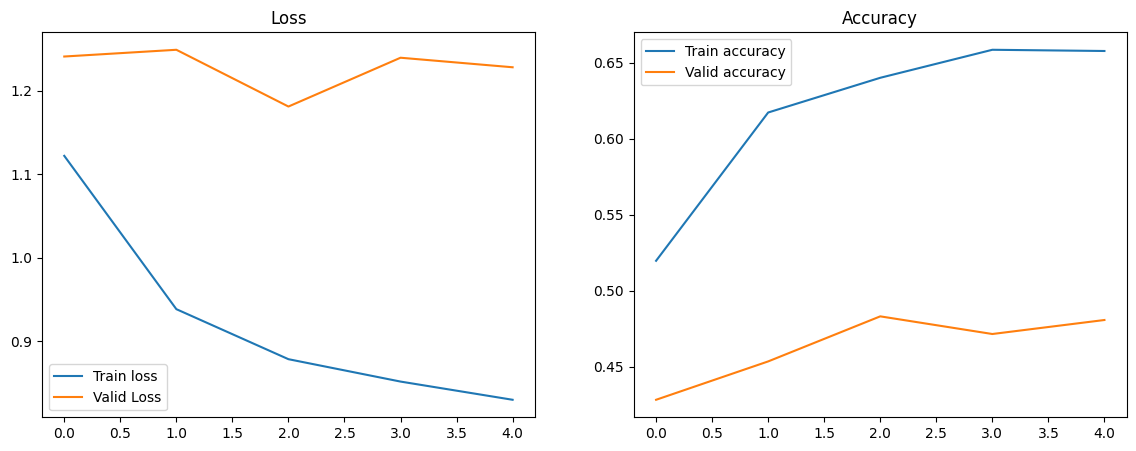

In [22]:
train_acc, train_loss, valid_acc, valid_loss = fit(model, 5)
plot_loss_metrics(train_loss, valid_loss, train_acc, valid_acc)